Face Recognition System
=============
In this notebook I will follow the process of generating a PCA decomposition of a face dataset that was given in a MATLAB structure from the ETSETB Biometrics subject. 
The Principal Component Analysis of the input data will produce the so called eigenfaces, which I will use to build a classification system using a k-Nearest Neighbours approach. That will give us the recognition of the different subjects in the dataset. The database is composed of 15 subjects, where each one is pictured in 6 different poses. The data will be used as follows:
* 3 poses for PCA estimation (1,2,3)
* 2 poses for training (4,5)
* 1 pose for testing (6)


In [4]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

db_path='db/'

#Load the different data from the matlab structures
#Load PCA face poses 
pca_faces = sio.loadmat(db_path+'pcafaces.mat') 
#Load training face poses 
train_faces = sio.loadmat(db_path+'trfaces.mat')
#Load test face poses 
test_faces = sio.loadmat(db_path+'tefaces.mat')

#Each structure has been read as a python dictionary now

Now that we have loaded all 3 subsets, I will make the Principal Component Analysis by means of a Singular Value Decomposition.

X ranges:  0.0 0.949019607843
X shape:  (307200, 45)
Number of Principal components:  45
Showing the first set of components
----------------------------------------------------------------------------------------------------


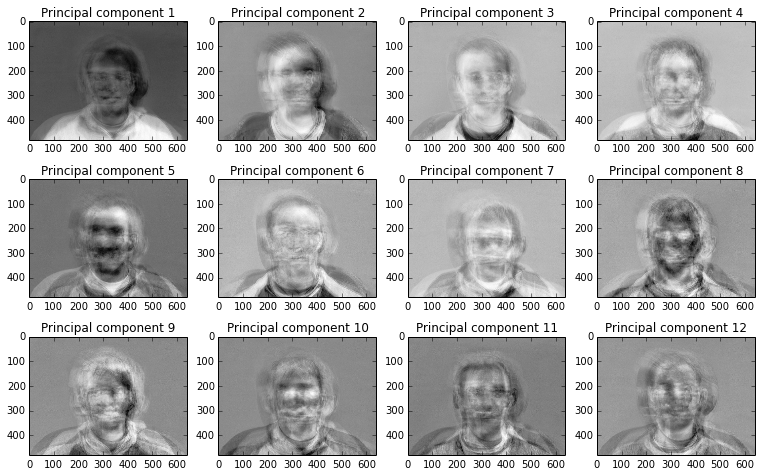

In [5]:
# Obtain unrolled images
X = np.transpose(pca_faces['X'])
print "X ranges: ",X.min(), X.max()
#Configure the number of PCs wanted: (0 means all)
P=0
#obtain original images size
i_cols = pca_faces['nb_colonnes']
i_rows = pca_faces['nb_lignes']

#----------------------------------

#each column is a different face, each row is a pixel from the corresponding face image
print "X shape: ", X.shape

#compute the mean face
m_face = np.mean(X,axis=1)

X_pca = np.zeros(X.shape)
#substract the mean, this is important to make a proper PCA without biasings
for col in xrange(X.shape[1]):
    X_pca[:,col] = X[:,col] - m_face # now we have a mean matrix

#Make a Singular Value Decomposition to obtain the principal components (eigenfaces)
U, s, Vt = np.linalg.svd(X_pca,full_matrices=False)
S = np.diag(s)

#Taking the P principal components means taking the first P columns of the U orthonormal matrix
if(not P):
    PC = U[:,:]
    P = S.shape[0]
else:
    PC = U[:,:P]
print "Number of Principal components: ", PC.shape[1]
print "Showing the first set of components"
print "-"*100

#Plot the principal components stored
fig = plt.gcf()
fig.set_size_inches(13, 8)
for colIdx in xrange(PC.shape[1]):
    if colIdx+1 > 3*4:
        break
    plt.subplot(3,4,colIdx+1)
    plt.imshow(PC[:,colIdx].reshape((i_rows,i_cols), order='F'), cmap=cm.Greys_r)
    plt.title('Principal component '+str(colIdx+1))


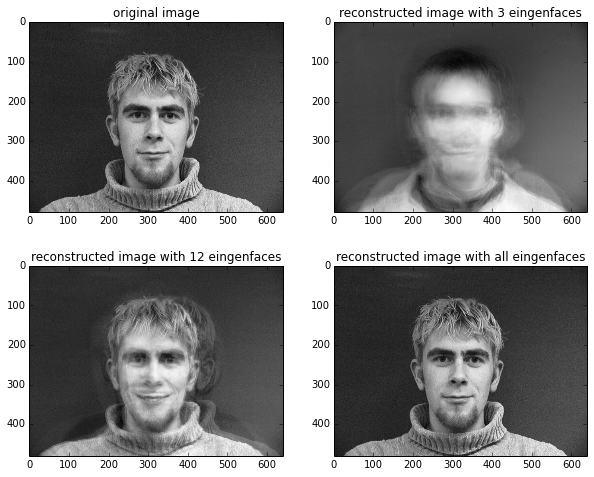

In [6]:
#Let me depict the reconstruction of an image by means of the PCA with different components
#we will see the original image and 3 reconstructions varying the P selected components
#pick up the first image of the dataset and extract the mean face
img = np.transpose(pca_faces['X'])[:,0]-m_face

#make both showings to compare original against reconstructed
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.subplot(2,2,1)
plt.title('original image')
plt.imshow((X[:,0]).reshape((i_rows,i_cols),order='F'),cmap=cm.Greys_r)

P = [3,12,-1] # -1 means all
pidx=2
#project onto the Principal Components
for p in P:
    decomposition = np.transpose(img).dot(PC[:,:p])
    #reconstruct the images adding the mean face
    reconstruction = m_face + decomposition.dot(np.transpose(PC[:,:p]))
    #show the result
    plt.subplot(2,2,pidx)
    pidx += 1
    if p == -1:
        plt.title('reconstructed image with all eingenfaces')
    else:
        plt.title('reconstructed image with '+ str(p) +' eingenfaces')
    plt.imshow(reconstruction.reshape((i_rows,i_cols), order='F'),cmap=cm.Greys_r)




Next step now is projecting the training data onto the Principal Components and then store that representation with their labels to make the k-NN classifier

In [7]:
train_set = np.transpose(train_faces['X'])
tr_number_ids = train_faces['numeros_individus']
tr_number_poses = train_faces['numeros_postures']
X_tr = np.zeros((train_set.shape))
for idxCol in xrange(train_set.shape[1]):
    X_tr[:,idxCol] = train_set[:,idxCol] - m_face

train_projection = np.transpose(X_tr).dot(PC)


labels = []
#save the training vectors with their classes
for n in tr_number_ids[0]:
    for m in xrange(tr_number_poses.shape[1]):
        labels.append(n)
lab_arr = np.array(labels,np.uint8).reshape(train_projection.shape[0],1)

#append the labels array to the training projections to have the labels with the features
train_projection = np.append(train_projection, lab_arr, axis=1)
print "Training projection + labels size: ", train_projection.shape

Training projection + labels size:  (30, 46)


Now that we have the training set after the PCA and with the labels appended, we can perform the test with a k-NN classifier as stated previously, using as a cost function the euclidean distance, such that:

![Image of distance](images/euclidean.png)

![Image of distance](images/kNN.gif)

This distance is computed for every newcoming test point with the k closest training points. In this example there are 8 training points and 4 test points. Process will be:
* For the new test point inserted, the euclidean distance is computed and the k closest training points are selected
* There is a voting process for how many points in each class fall into that minimum distance
* The test point is labeled with the most repeated class in those k points


In [8]:
test_set = np.transpose(test_faces['X'])
te_number_ids = test_faces['numeros_individus']
te_number_poses = test_faces['numeros_postures']
X_te = np.zeros((test_set.shape))
for idxCol in xrange(test_set.shape[1]):
    X_te[:,idxCol] = test_set[:,idxCol] - m_face
#make the test PCA 
test_projection = np.transpose(X_te).dot(PC)

#define the kNN function to return the most voted k nearest label
def kNN(train_set, test_sample, K=1):
    #compute all distances first
    distances = np.zeros(train_set.shape[0])
    for train_idx in xrange(train_set.shape[0]):
        diff = train_set[train_idx,:-1]-test_sample
        distances[train_idx] = np.sqrt((diff).dot(np.transpose(diff)))
    sort_distances = np.sort(distances)    
    #initialize the classes voting counter
    classes = np.zeros(train_set[:,-1].max())
    #get the k nearest neighbours and proceed with the voting
    for k in xrange(K):
        if k>=len(sort_distances): 
            break
        nearest_idx = np.where(distances == sort_distances[k])
        classes[train_set[nearest_idx[0][0],-1]-1] += 1
    return np.argmax(classes)+1
#get the groundtruth labels
labels = []
#save the training vectors with their classes
for n in te_number_ids[0]:
    for m in xrange(te_number_poses.shape[1]):
        labels.append(n)

#First execution is with k=1
def compute_accuracy(test_projection,K,verbose=True):
    accuracy = 0
    for idx in xrange(test_projection.shape[0]):
        prediction = kNN(train_projection, test_projection[idx,:],K)
        if verbose:
            print "prediction: ", prediction , " groundtruth: ", labels[idx]
        if(prediction == labels[idx]):
            accuracy += 1.
    accuracy /= test_projection.shape[0]
    return accuracy
acc = compute_accuracy(test_projection,1)
print "Test accuracy of 1-NN is: ", acc*100., "%"


prediction:  1  groundtruth:  1
prediction:  2  groundtruth:  2
prediction:  3  groundtruth:  3
prediction:  4  groundtruth:  4
prediction:  5  groundtruth:  5
prediction:  6  groundtruth:  6
prediction:  7  groundtruth:  7
prediction:  8  groundtruth:  8
prediction:  9  groundtruth:  9
prediction:  10  groundtruth:  10
prediction:  11  groundtruth:  11
prediction:  12  groundtruth:  12
prediction:  13  groundtruth:  13
prediction:  10  groundtruth:  14
prediction:  15  groundtruth:  15
Test accuracy of 1-NN is:  93.3333333333 %


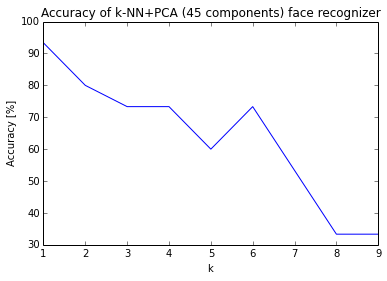

In [9]:
#Now a curve with accuracy depending on K value is generated
accs = []
K = range(1,10)
for k in K:
    accs.append(100.*compute_accuracy(test_projection,k,verbose=False))

plt.plot(K,accs,'b-')
plt.title('Accuracy of k-NN+PCA (' +str(PC.shape[1]) +' components) face recognizer')
plt.xlabel('k')
plt.ylabel('Accuracy [%]')
plt.show()
    